In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, confusion_matrix
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from utils import metrics, plots
pd.set_option("display.max_rows", None)

In [5]:
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
# read data
train = pd.read_csv('../Data/CMaps/train_FD001.txt',sep='\s+', header=None, names=col_names)
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [6]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [7]:
# Remove those column as we can see that it's value is not changing
cols_to_drop = ['setting_3', 's_1', 's_5', 's_6', 's_10', 's_14', 's_16', 's_18', 's_19']
train=train.drop(cols_to_drop, axis=1)
# Adding RUL (Remining Useful Life) to the train dataset
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
train = add_remaining_useful_life(train)
#train[sensor_names+['RUL']].head()
train.head(5)
train.isna().sum()

unit_nr        0
time_cycles    0
setting_1      0
setting_2      0
s_2            0
s_3            0
s_4            0
s_7            0
s_8            0
s_9            0
s_11           0
s_12           0
s_13           0
s_15           0
s_17           0
s_20           0
s_21           0
RUL            0
dtype: int64

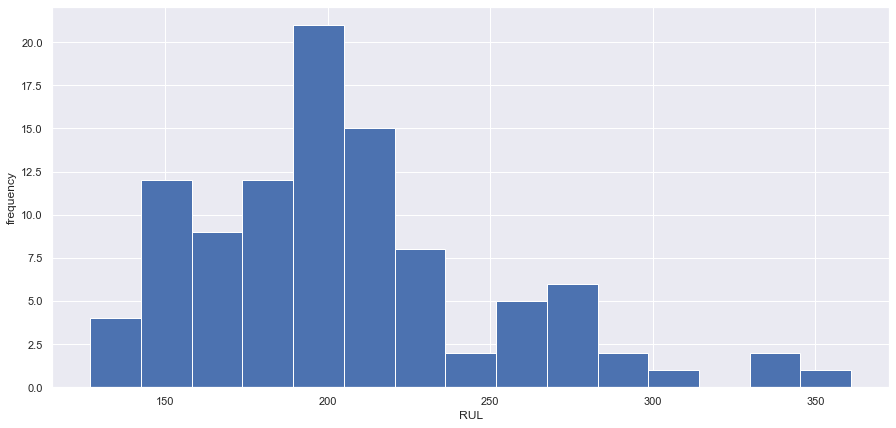

In [8]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [9]:
# Checking how values RUL are distributed into various quantiles.
train['RUL'].quantile([.1, .25, .5, .75, 0.9])

0.10     20.0
0.25     51.0
0.50    103.0
0.75    155.0
0.90    198.0
Name: RUL, dtype: float64

In [10]:
train['Class'] = pd.cut(x=train['RUL'], bins=[-1,51,103,155,361], labels=['Inception','Healthy','Mature','Attention_Required'])
train.shape

(20631, 19)

In [11]:
# Splitting of Independent & Dependent Variable and train input and output data
X = train.drop(axis=0, columns=['Class','unit_nr','time_cycles','RUL'])
Y = train.Class
from sklearn.model_selection import train_test_split
# Split into training and test sets
X_train, X_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.33, random_state=42)
y_train=y_train.astype('object')
X_train.shape, X_validate.shape

((13822, 15), (6809, 15))

In [13]:
num_of_classes = len(train.Class.unique())
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn import preprocessing
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validate = le.fit_transform(y_validate)
#print(y_train, y_validate)
xgb = XGBClassifier()
xgb.fit(X=X_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [14]:
# Predicting results on Train Dataset
val = xgb.predict(X_train)
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_train_lb = lb.transform(y_train)
val_lb = lb.transform(val)
print("roc score for train dataset: ", roc_auc_score(y_train_lb, val_lb, average='macro'))
# Predicting results on Validation Dataset
val = xgb.predict(X_validate)
lb = preprocessing.LabelBinarizer()
lb.fit(y_validate)
y_validate_lb = lb.transform(y_validate)
val_lb = lb.transform(val)
print("roc score for validation dataset: ", roc_auc_score(y_validate_lb, val_lb, average='macro'))

roc score for train dataset:  0.9459916758715556
roc score for validation dataset:  0.7104338117477198


In [15]:
# Final Results in the form of dataset
output = pd.DataFrame()
output['Expected Output'] = y_validate
output['Predicted Output'] = val
output.tail()

,Expected Output,Predicted Output
6804,2,2
6805,1,2
6806,0,0
6807,0,0
6808,0,0


In [16]:
test = pd.read_csv('../Data/CMaps/test_FD001.txt', sep='\s+', header=None, names=col_names)
test.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [17]:
X_test = test.groupby('unit_nr').last().reset_index().drop(cols_to_drop, axis=1)
print(X_test.shape)
num_test_machines = len(X_test.unit_nr.unique())
print(num_test_machines)
X_test = X_test.drop(axis=0, columns=['unit_nr', 'time_cycles'])
X_test.shape

(100, 17)
100


(100, 15)

In [18]:
rul_pred = xgb.predict(X_test).reshape(-1)
rul_pred.shape

(100,)

In [24]:
y_true = pd.read_csv('../Data/CMaps/RUL_FD001.txt', delim_whitespace=True, names=["RUL"])
print(y_true.shape)
y_true['Class'] = pd.cut(x=y_true['RUL'], bins=[-1,51,103,155,361], labels=['Inception','Healthy','Mature','Attention_Required'])
y_true['Class'] = le.fit_transform(y_true['Class'])
y_true

(100, 1)


,RUL,Class
0,112,2
1,98,0
2,69,0
3,82,0
4,91,0
5,93,0
6,91,0
7,95,0
8,111,2
9,96,0


In [29]:
# Predicting results on test Dataset
lb = preprocessing.LabelBinarizer()
lb.fit(y_true.Class)
y_test_lb = lb.transform(y_true.Class)
val_lb = lb.transform(rul_pred)
print("roc score for test dataset: ", roc_auc_score(y_test_lb, val_lb, average='macro'))

roc score for test dataset:  0.37967715388698703
